In [1]:
!pip install torch torchvision

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
use_cuda = False
device = torch.device('cuda' if use_cuda else 'cpu')

# Experiment 1: Image Classification

In [67]:
# Default parameters from the PyTorch MNIST example (https://github.com/pytorch/examples/blob/master/mnist/main.py
params = dict(batch_size=64, batch_size_eval=1000, num_epochs=30, learning_rate=0.01, momentum=0.5)

## Load MNIST data and make a noisy variant

In [224]:
def load_mnist(val_size=5000):
    """Return the train (55k), val (5k, randomly drawn from the original test set) and test (10k) dataset for MNIST."""
    image_transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

    raw_train_dataset = datasets.MNIST('data/mnist', train=True, download=True, transform=image_transform)
    test_dataset = datasets.MNIST('data/mnist', train=False, download=True, transform=image_transform)

    # Split 5k samples from the train dataset for validation (similar to Sacramento et al. 2018).
    # TODO: Maybe seed this? Cannot be done in the method directly, so would need to manually call torch.seed. 
    train_dataset, val_dataset = torch.utils.data.dataset.random_split(raw_train_dataset, (len(raw_train_dataset)-val_size, val_size))
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = load_mnist()

In [327]:
def load_emnist(val_size=10000):
    """Return the train (55k), val (5k, randomly drawn from the original test set) and test (10k) dataset for MNIST."""
    image_transform = transforms.Compose([
                           transforms.RandomHorizontalFlip(1),  # EMNIST images are flipped and rotated by default
                           transforms.RandomRotation((90, 90)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])
    target_transform = lambda x: x-1  # make labels start at 0 instead of 1

    raw_train_dataset = datasets.EMNIST('data/emnist', split='letters', train=True, download=True, transform=image_transform, target_transform=target_transform)
    test_dataset = datasets.EMNIST('data/emnist', split='letters', train=False, download=True, transform=image_transform, target_transform=target_transform)

    # Split 5k samples from the train dataset for validation (similar to Sacramento et al. 2018).
    # TODO: Maybe seed this? Cannot be done in the method directly, so would need to manually call torch.seed. 
    train_dataset, val_dataset = torch.utils.data.dataset.random_split(raw_train_dataset, (len(raw_train_dataset)-val_size, val_size))
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = load_emnist()

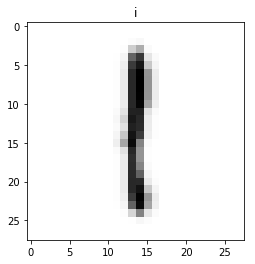

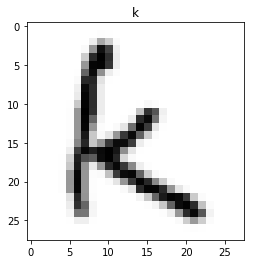

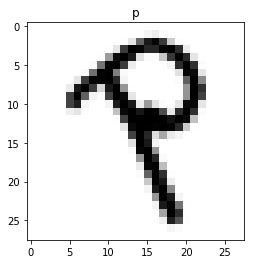

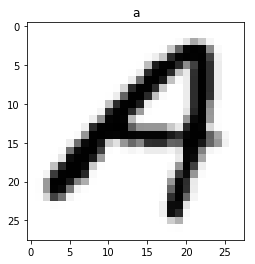

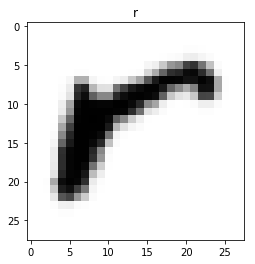

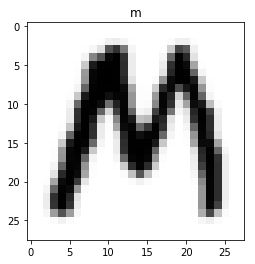

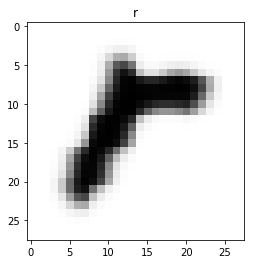

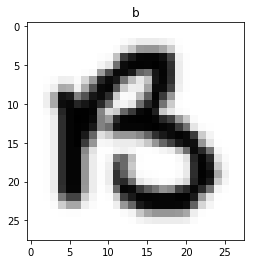

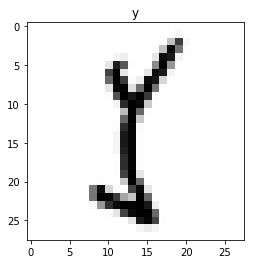

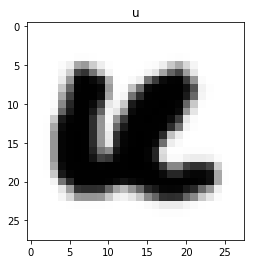

In [328]:
for i in range(10):
    plt.figure()
    plt.imshow(train_dataset[i][0][0], cmap='Greys')
    plt.title('abcdefghijklmnopqrstuvwxyz'[train_dataset[i][1].item()])

In [329]:
labels = [sample[1] for sample in test_dataset]
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

In [330]:
kwargs = {'num_workers': 3, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=params['batch_size_eval'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)

In [209]:
# Temporary workaround to process the emnist dataset, because it cannot automatically be 
# downloaded through pytorch (due to the shutdown). 
def process_emnist():

    def get_int(b):
        return int(codecs.encode(b, 'hex'), 16)

    def read_label_file(path):
        with open(path, 'rb') as f:
            data = f.read()
            assert get_int(data[:4]) == 2049
            length = get_int(data[4:8])
            parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
            return torch.from_numpy(parsed).view(length).long()

    def read_image_file(path):
        with open(path, 'rb') as f:
            data = f.read()
            assert get_int(data[:4]) == 2051
            length = get_int(data[4:8])
            num_rows = get_int(data[8:12])
            num_cols = get_int(data[12:16])
            images = []
            parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
            return torch.from_numpy(parsed).view(length, num_rows, num_cols)

    splits = ('byclass', 'bymerge', 'balanced', 'letters', 'digits', 'mnist')

    def _training_file(split):
        return 'training_{}.pt'.format(split)

    def _test_file(split):
        return 'test_{}.pt'.format(split)

    import os
    import codecs
    from six.moves import urllib
    import gzip
    import shutil
    import zipfile
    
    root = 'data/emnist'
    processed_folder = 'processed'
    raw_folder = 'data/emnist/raw'

    # process and save as torch files
    for split in splits:
        print('Processing ' + split)
        training_set = (
            read_image_file(os.path.join(raw_folder, 'emnist-{}-train-images-idx3-ubyte'.format(split))),
            read_label_file(os.path.join(raw_folder, 'emnist-{}-train-labels-idx1-ubyte'.format(split)))
        )
        test_set = (
            read_image_file(os.path.join(raw_folder, 'emnist-{}-test-images-idx3-ubyte'.format(split))),
            read_label_file(os.path.join(raw_folder, 'emnist-{}-test-labels-idx1-ubyte'.format(split)))
        )
        with open(os.path.join(root, processed_folder, _training_file(split)), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(root, processed_folder, _test_file(split)), 'wb') as f:
            torch.save(test_set, f)

    print('Done!')

In [119]:
from PIL import Image

class AddGaussianNoise(object):
    def __init__(self, mean=0, std=64, scaling_factor=0.5):
        self.mean = mean
        self.std = std
        self.scaling_factor = scaling_factor
    
    def __call__(self, img):
        img_array = np.asarray(img)
        noisy_img_array = img_array + self.scaling_factor * np.random.normal(self.mean, self.std, img_array.shape)
        noisy_img_array = np.clip(noisy_img_array, 0, 255)
        noisy_img_array = noisy_img_array.astype(img_array.dtype)
        return Image.fromarray(noisy_img_array)
        
    def __repr__(self):
        return self.__class__.__name__ + '(mean={}, std={}, scaling_factor={})'.format(self.mean, self.std, self.intensity)

In [255]:
# TODO: Maybe use normal load methods from above here and exchange the transform. 
def load_noisy_mnist(mean=0, std=64, scaling_factor=0.5):
    """Return the test dataset of MNIST with added Gaussian noise."""
    image_transform = transforms.Compose([
                           AddGaussianNoise(mean=mean, std=std, scaling_factor=scaling_factor),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])
    
    return datasets.MNIST('data/mnist', train=False, download=True, transform=image_transform)

noisy_test_dataset = load_noisy_mnist(scaling_factor=2)
noisy_test_loader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)

In [331]:
def load_noisy_emnist(mean=0, std=64, scaling_factor=0.5):
    """Return the test dataset of MNIST with added Gaussian noise."""
    image_transform = transforms.Compose([
                           transforms.RandomHorizontalFlip(1),  # EMNIST images are flipped and rotated by default
                           transforms.RandomRotation((90, 90)),
                           AddGaussianNoise(mean=mean, std=std, scaling_factor=scaling_factor),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])
    target_transform = lambda x: x-1  # make labels start at 0 instead of 1
    
    return datasets.EMNIST('data/emnist', split='letters', train=False, download=True, transform=image_transform, target_transform=target_transform)

noisy_test_dataset = load_noisy_emnist(scaling_factor=2)
noisy_test_loader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)

In [84]:
#plt.imshow(noisy_test_dataset[4][0])

## Networks

In [230]:
class FeedforwardNet(nn.Module):
    # TODO: Add ability to easily add more hidden layers. 
    def __init__(self, num_hidden=500, dropout=0.5):
        super(FeedforwardNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 26)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.forward1(x))
        x = self.dropout(x)
        x = self.forward2(x)
        # TODO: Maybe change to loss function that includes softmax. 
        return F.log_softmax(x, dim=1)

In [73]:
class FeedbackNet(nn.Module):
    def __init__(self, num_hidden=500, dropout=0.5):
        super(FeedbackNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 10)
        self.dropout = nn.Dropout(dropout)
        
        self.feedback1 = nn.Linear(num_hidden, 784)
        self.feedback2 = nn.Linear(10, num_hidden)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        inp = inp.view(-1, 784)
        
        x = F.relu(self.forward1(inp))
        feedback_activation_1 = self.feedback1(x)
        
        x = self.dropout(x)
        x = F.log_softmax(self.forward2(x), dim=1)
        feedback_activation_2 = self.feedback2(x)
        # TODO: Maybe change to loss function that includes softmax. 
        
        #print(feedback_activation_1.shape, feedback_activation_2.shape)
        
        # 2nd forward pass, this time with added feedback
        x = F.relu(self.forward1(inp + feedback_activation_1))
        # TODO: Do dropout again here or only on the first pass?
        #x = F.dropout(x, training=self.training)
        x = F.log_softmax(self.forward2(x + feedback_activation_2), dim=1)
        
        return x
        

In [74]:
class ConvNet(nn.Module):
    """ConvNet from the official PyTorch tutorial, achieves around 98 % accuracy on test set (https://github.com/pytorch/examples/blob/master/mnist/main.py)."""
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Training

In [231]:
def train(model, device, train_loader, optimizer, epoch, params=None):
    model.train()
    for batch, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # TODO: Change to loss_function = ..., loss_function(output, target)
        #print(output.shape, target.shape)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(data), len(train_loader.dataset),
                100. * batch / len(train_loader), loss.item()))

In [232]:
def test(model, device, test_loader, params=None):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # TODO: Change to loss_function = ..., loss_function(output, target)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [235]:
def count_parameters(model):
    return sum(p.numel() for p in filter(lambda p: p.requires_grad, model.parameters()) if p.requires_grad)

In [250]:
import time

model = FeedforwardNet(num_hidden=500).to(device)
#model = FeedbackNet().to(device)
print('Model has', count_parameters(model), 'trainable parameters')

# TODO: Maybe use Adam or Adadelta instead. 
optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'])

for epoch in range(params['num_epochs']):
    print('Epoch {}/{}'.format(epoch+1, params['num_epochs']))
    start_time = time.time()
    train(model, device, train_loader, optimizer, epoch+1)
    print('Took', time.time()-start_time, 'seconds')
    test(model, device, test_loader)
    print('Now testing on noisy dataset...')
    test(model, device, noisy_test_loader)

Model has 405526 trainable parameters
Epoch 1/30
Train Epoch: 1 [0/114800 (0%)]	Loss: 3.364546
Train Epoch: 1 [6400/114800 (6%)]	Loss: 1.883056
Train Epoch: 1 [12800/114800 (11%)]	Loss: 1.774883
Train Epoch: 1 [19200/114800 (17%)]	Loss: 1.521679
Train Epoch: 1 [25600/114800 (22%)]	Loss: 1.308522
Train Epoch: 1 [32000/114800 (28%)]	Loss: 1.216146
Train Epoch: 1 [38400/114800 (33%)]	Loss: 0.981548
Train Epoch: 1 [44800/114800 (39%)]	Loss: 1.251293
Train Epoch: 1 [51200/114800 (45%)]	Loss: 1.232695
Train Epoch: 1 [57600/114800 (50%)]	Loss: 1.112284
Train Epoch: 1 [64000/114800 (56%)]	Loss: 0.856672
Train Epoch: 1 [70400/114800 (61%)]	Loss: 0.995457
Train Epoch: 1 [76800/114800 (67%)]	Loss: 1.025760
Train Epoch: 1 [83200/114800 (72%)]	Loss: 0.955970
Train Epoch: 1 [89600/114800 (78%)]	Loss: 0.967802
Train Epoch: 1 [96000/114800 (84%)]	Loss: 0.763317
Train Epoch: 1 [102400/114800 (89%)]	Loss: 0.982318
Train Epoch: 1 [108800/114800 (95%)]	Loss: 0.898482
Took 18.13324499130249 seconds

Test s

Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode=L size=28x28 at 0x11B654390>>
Traceback (most recent call last):
  File "/Users/jrieke/anaconda2/envs/py3/lib/python3.6/site-packages/PIL/Image.py", line 587, in __del__
    if (hasattr(self, 'fp') and hasattr(self, '_exclusive_fp')
KeyboardInterrupt


Train Epoch: 4 [44800/114800 (39%)]	Loss: 0.494759
Train Epoch: 4 [51200/114800 (45%)]	Loss: 0.500844
Train Epoch: 4 [57600/114800 (50%)]	Loss: 0.732430
Train Epoch: 4 [64000/114800 (56%)]	Loss: 0.646362
Train Epoch: 4 [70400/114800 (61%)]	Loss: 0.496812
Train Epoch: 4 [76800/114800 (67%)]	Loss: 0.557956
Train Epoch: 4 [83200/114800 (72%)]	Loss: 0.721928
Train Epoch: 4 [89600/114800 (78%)]	Loss: 0.537880
Train Epoch: 4 [96000/114800 (84%)]	Loss: 0.474111
Train Epoch: 4 [102400/114800 (89%)]	Loss: 0.480194
Train Epoch: 4 [108800/114800 (95%)]	Loss: 0.340640
Took 20.938366413116455 seconds

Test set: Average loss: 0.4398, Accuracy: 18040/20800 (87%)

Now testing on noisy dataset...

Test set: Average loss: 5.2038, Accuracy: 465/10000 (5%)

Epoch 5/30
Train Epoch: 5 [0/114800 (0%)]	Loss: 0.623673
Train Epoch: 5 [6400/114800 (6%)]	Loss: 0.547669
Train Epoch: 5 [12800/114800 (11%)]	Loss: 0.555407
Train Epoch: 5 [19200/114800 (17%)]	Loss: 0.599290
Train Epoch: 5 [25600/114800 (22%)]	Loss: 0.

KeyboardInterrupt: 

# Experiment 2: Sequential Image Classification

In [3]:
params = dict(batch_size=64, batch_size_eval=1000, num_epochs=30, learning_rate=0.01, momentum=0.5)

## Load MNIST dataset and arrange digits in sequences

In [377]:
import random

class ImageSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, allowed_seqs, image_dataset, num_classes, num_samples=10000, noisy_image_dataset=None):
        self.num_samples = num_samples
        self.allowed_seqs = allowed_seqs
        self.images_per_class = self.split_images_into_classes(image_dataset, num_classes)
        if noisy_image_dataset is None:
            self.add_noise = False
        else:
            self.add_noise = True
            self.noisy_images_per_class = self.split_images_into_classes(noisy_image_dataset, num_classes)
            
    def split_images_into_classes(self, dataset, num_classes):
        images_per_class = {i: [] for i in range(num_classes)}
        for image, class_ in dataset:
            images_per_class[class_.item()].append(image)
        return images_per_class
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, i):
        seq = self.allowed_seqs[i % len(self.allowed_seqs)]
        if self.add_noise:
            images = [random.choice(self.images_per_class[class_]) for class_ in seq[:3]] + [random.choice(self.noisy_images_per_class[class_]) for class_ in seq[3:]]
        else:
            images = [random.choice(self.images_per_class[class_]) for class_ in seq]
        return torch.cat(images), seq

In [378]:
def to_letter(index):
    return 'abcdefghijklmnopqrstuvwxyz'[index]

def to_index(letter):
    return ord(letter) - 97

def plot_image_sequence(images, targets):
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i], cmap='Greys')
        plt.axis('off')
        plt.title(to_letter(targets[i]))

In [379]:
to_index('b')

1

In [380]:
num_allowed_seqs = 10
seq_len = 5
num_classes = 26  # mnist: 10, emnist: 26

allowed_seqs = np.random.randint(0, num_classes, (num_allowed_seqs, seq_len))

In [407]:
allowed_seqs_letters = np.loadtxt('data/5-letter-words.txt', dtype=str)
# Use only 10 words for now.
allowed_seqs_letters = np.random.choice(allowed_seqs_letters, 50)
allowed_seqs = np.array([list(map(to_index, word)) for word in allowed_seqs_letters])

In [408]:
allowed_seqs, allowed_seqs_letters[:10]

(array([[ 8, 13, 13,  4, 17],
        [ 5, 17,  0, 12,  4],
        [15,  4,  0,  2,  4],
        [ 2, 11, 14,  2, 10],
        [ 1, 11,  0,  2, 10],
        [ 5, 14, 17, 19, 24],
        [22, 14, 17, 11,  3],
        [21,  8, 19,  0, 11],
        [22, 14, 17, 19,  7],
        [18,  7, 14, 22, 13],
        [ 0, 13,  6, 17, 24],
        [ 4, 13,  9, 14, 24],
        [18, 14, 20, 19,  7],
        [ 1, 11,  0,  2, 10],
        [ 5, 14,  2, 20, 18],
        [ 4, 21,  4, 13, 19],
        [12,  0, 10,  4, 17],
        [19, 17,  8,  0, 11],
        [15,  7, 14, 13,  4],
        [11, 20,  2, 10, 24],
        [ 3, 17,  4, 18, 18],
        [17, 14,  1,  8, 13],
        [ 2,  7,  8,  4,  5],
        [18, 10,  8, 11, 11],
        [ 6, 14,  8, 13,  6],
        [ 1, 11,  0, 12,  4],
        [20, 18,  0,  6,  4],
        [17,  8, 21,  0, 11],
        [13,  4,  4,  3, 18],
        [21,  8, 18,  8, 19],
        [ 7, 14, 20, 18,  4],
        [ 1, 17, 14, 10,  4],
        [ 0, 11,  8, 21,  4],
        [ 

In [409]:
np.unique(allowed_seqs, return_counts=True)
# TODO: Some letters appear very rarely in these words, gotta keep this in mind when training only on sequences. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17,
        18, 19, 20, 21, 22, 23, 24]),
 array([17,  7,  8,  5, 28,  5,  6, 10, 17,  2,  8, 17,  3, 16, 18,  6, 16,
        17, 15,  8,  6,  6,  1,  8]))

In [410]:
train_dataset, val_dataset, test_dataset = load_emnist()#load_mnist()
noisy_test_dataset = load_noisy_emnist(scaling_factor=4)#load_noisy_mnist(scaling_factor=4)

seq_train_dataset = ImageSequenceDataset(allowed_seqs, train_dataset, num_classes, num_samples=50000)
seq_test_dataset = ImageSequenceDataset(allowed_seqs, test_dataset, num_classes, num_samples=10000)
noisy_seq_test_dataset = ImageSequenceDataset(allowed_seqs, test_dataset, num_classes, num_samples=10000, noisy_image_dataset=noisy_test_dataset)

kwargs = {'num_workers': 3, 'pin_memory': True} if use_cuda else {}
seq_train_loader = torch.utils.data.DataLoader(seq_train_dataset, batch_size=params['batch_size'], shuffle=True, **kwargs)
seq_test_loader = torch.utils.data.DataLoader(seq_test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)
noisy_seq_test_loader = torch.utils.data.DataLoader(noisy_seq_test_dataset, batch_size=params['batch_size_eval'], shuffle=False, **kwargs)

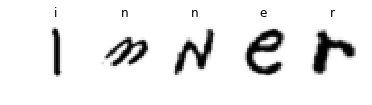

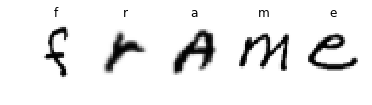

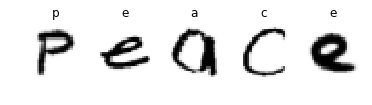

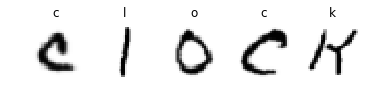

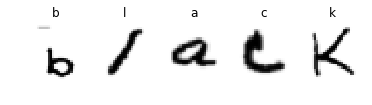

In [411]:
for i in range(5):
    plt.figure()
    plot_image_sequence(*seq_test_dataset[i])

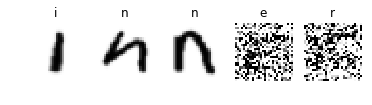

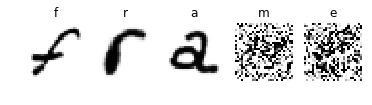

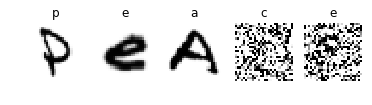

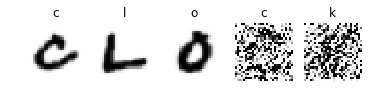

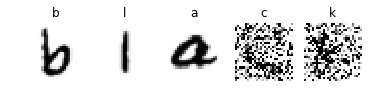

In [412]:
for i in range(5):
    plt.figure()
    plot_image_sequence(*noisy_seq_test_dataset[i])

## Networks

In [14]:
class SequentialLSTM(nn.Module):
    def __init__(self, num_hidden=500):
        super(SequentialLSTM, self).__init__()
        # TODO: Maybe change everything to batch_second.
        self.lstm1 = nn.LSTM(784, num_hidden, batch_first=True)
        self.lstm2 = nn.LSTM(num_hidden, 10, batch_first=True)
        
    def forward(self, inp):
        inp = inp.view(inp.shape[0], inp.shape[1], 784)
        #print(inp.shape)
        x, (hidden, cell) = self.lstm1(inp)
        # TODO: Need to add a non-linearity here?
        x, (hidden, cell) = self.lstm2(x)
        #print(x.shape, hidden.shape, cell.shape)
        #print(x.shape)
        x = F.log_softmax(x, dim=2)
        #print(x.sum(dim=(2)))
        return x

In [393]:
class SequentialFeedforwardNet(nn.Module):
    def __init__(self, num_hidden=500, dropout=0.5):
        super(SequentialFeedforwardNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 26)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        outp = torch.zeros(inp.shape[0], inp.shape[1], 26)
        
        for i, x in enumerate(inp.transpose(0, 1)):
            x = x.view(-1, 784)
            x = F.relu(self.forward1(x))
            x = self.dropout(x)
            x = self.forward2(x)
            # TODO: Maybe change to loss function that includes softmax. 
            x = F.log_softmax(x, dim=1)
            outp[:, i] = x
            
        return outp

In [394]:
class SequentialFeedbackNet(nn.Module):
    def __init__(self, num_hidden=500, dropout=0.5, alpha=0.5):
        super(SequentialFeedbackNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 26)
        self.dropout = nn.Dropout(dropout)
        
        self.feedback1 = nn.Linear(num_hidden, 784)
        self.feedback2 = nn.Linear(26, num_hidden)
        self.alpha = alpha
        
        self.dropout = nn.Dropout(dropout)
        self.no_feedback = False
        
    def forward(self, inp):
        outp = torch.zeros(inp.shape[0], inp.shape[1], 26)
        
        feedback_activation_1 = torch.zeros(inp.shape[0], self.forward1.weight.shape[1])
        feedback_activation_2 = torch.zeros(inp.shape[0], self.forward2.weight.shape[1])
        
        for i, x in enumerate(inp.transpose(0, 1)):
            x = x.view(-1, 784)
            #print(feedback_activation_1.mean())
            x = F.relu(self.forward1((1 - self.alpha) * x + self.alpha * feedback_activation_1))
            # TODO: Is this retained across forward passes?
            feedback_activation_1 = self.feedback1(x)  # for next forward pass
            x = self.dropout(x)
            x = self.forward2(x)
            #x = self.forward2((1 - self.alpha) * x +  self.alpha * feedback_activation_2)
            # TODO: Maybe change to loss function that includes softmax. 
            x = F.log_softmax(x, dim=1)
            feedback_activation_2 = self.feedback2(x)  # for next forward pass
            outp[:, i] = x
            
        return outp

    def forward_old(self, inp):
        # inp shape: batch_size, time_steps, 28, 28
        # TODO: Maybe change to batch_second. 
        output = torch.zeros(inp.shape[0], inp.shape[1], 10)  # shape: batch_size, time_steps, 10
        
        for i, x in enumerate(inp.transpose(0, 1)):  # iterate over time dimension
            #print(x.shape)
            
            x = x.view(-1, 784)  # shape: batch_size, 784
            # TODO: Implement multiple feedback passes. 
            
            if i == 0 or self.no_feedback:
                x = self.forward1(x)
            else:
                print(feedback_activation_1.shape)
                #plt.imshow(feedback_activation_1.detach()[0].view(28, 28))
                x = self.forward1(x + self.alpha * feedback_activation_1)
            x = F.relu(x)
            if not self.no_feedback:
                feedback_activation_1 = self.feedback1(x)

            x = self.dropout(x)
            if i == 0 or self.no_feedback:
                x = self.forward2(x)
            else:
                x = self.forward2(x + self.alpha * feedback_activation_2)
            x = F.log_softmax(x, dim=1)
            if not self.no_feedback:
                feedback_activation_2 = self.feedback2(x)

            output[:, i] = x
    
        return output
        

In [54]:
imgs = seq_train_dataset[0][0]
model = SequentialFeedbackNet()
model.forward1.weight.data = ff_model.forward1.weight.data.clone()
model.forward1.bias.data = ff_model.forward1.bias.data.clone()
model.forward2.weight.data = ff_model.forward2.weight.data.clone()
model.forward2.bias.data = ff_model.forward2.bias.data.clone()
model(imgs[None], no_feedback=False)

NameError: name 'ff_model' is not defined

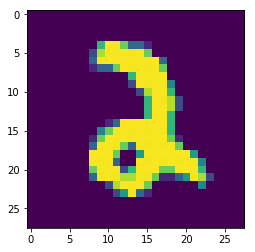

In [172]:
plt.imshow(imgs[0])

## Training

In [63]:
# Good template for hyperparameter optimization:
#def run(train_dataset, val_dataset, device, params, history)
#def 

In [373]:
# TODO: Debug properly.
def train_sequential(model, device, train_loader, optimizer, epoch, params=None):
    model.train()
    for batch, (data, target) in enumerate(seq_train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        #print(output.shape, target.shape)
        
        # TODO: According to https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
        #       need to do model.zero_grad() and model.hidden = model.init_hidden() here. 

        loss = F.nll_loss(output.transpose(1, 2), target)  # loss function requires transpose
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(data), len(train_loader.dataset),
                100. * batch / len(train_loader), loss.item()))

In [447]:
# TODO: Debug properly.
def test_sequential(model, device, test_loader, per_position=False, params=None):
    model.eval()
    test_loss = 0
    correct = 0
    if per_position:
        correct_per_position = torch.zeros(seq_len)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.transpose(1, 2), target, reduction='sum').item() # sum up batch loss, loss function requires transpose
            
            pred = output.view(-1, output.shape[-1]).max(1, keepdim=True)[1].view_as(target) # get the index of the max log-probability
            correct += (pred == target).sum().item()
            if per_position:
                correct_per_position += (pred == target).float().sum(0)

    # TODO: Make this independent of seq_len (used twice!).
    test_loss /= len(test_loader.dataset) * seq_len
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f} %)'.format(
        test_loss, correct, len(test_loader.dataset) * seq_len,
        100. * correct / (len(test_loader.dataset) * seq_len)))
    if per_position:
        print('Accuracy per position:', ' | '.join(['{:.1f} %'.format(100. * corr.item() / len(test_loader.dataset)) for corr in correct_per_position]))

In [17]:
len([p for p in model.parameters() if p.requires_grad])

NameError: name 'model' is not defined

In [450]:
#model = SequentialFeedforwardNet().to(device)
#model = SequentialLSTM().to(device)
model = SequentialFeedbackNet(dropout=0.5, alpha=0.5).to(device)
# TODO: Use rmsprop or another optimizer which is good for LSTMs.
#optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.0001, momentum=params['momentum'])
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=params['momentum'])

for epoch in range(params['num_epochs']):
    print('Epoch {}/{}'.format(epoch+1, params['num_epochs']))
    start_time = time.time()
    train_sequential(model, device, seq_train_loader, optimizer, epoch+1)
    print('Took', time.time()-start_time, 'seconds')
    
    print()
    test_sequential(model, device, seq_test_loader, per_position=True)
    print()
    print('Now testing on noisy dataset...')
    test_sequential(model, device, noisy_seq_test_loader, per_position=True)
    print()

Epoch 1/30
Train Epoch: 1 [0/50000 (0%)]	Loss: 3.280133
Train Epoch: 1 [6400/50000 (13%)]	Loss: 3.196204
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.972905
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.747561
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.592580
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.386707
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.225028
Train Epoch: 1 [44800/50000 (90%)]	Loss: 2.166148
Took 16.692970037460327 seconds

Test set: Average loss: 1.8673, Accuracy: 22048/50000 (44.1 %)
Accuracy per position: 28.2 % | 53.9 % | 41.3 % | 49.1 % | 47.9 %

Now testing on noisy dataset...
Test set: Average loss: 2.2142, Accuracy: 16620/50000 (33.2 %)
Accuracy per position: 28.6 % | 54.6 % | 41.8 % | 19.5 % | 21.8 %

Epoch 2/30
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.926338
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.741465
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.709211
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.566834
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.379108
Train Epoch: 2 

Train Epoch: 12 [19200/50000 (38%)]	Loss: 0.602999
Train Epoch: 12 [25600/50000 (51%)]	Loss: 0.662686
Train Epoch: 12 [32000/50000 (64%)]	Loss: 0.933930
Train Epoch: 12 [38400/50000 (77%)]	Loss: 0.678953
Train Epoch: 12 [44800/50000 (90%)]	Loss: 0.834900
Took 16.62908411026001 seconds

Test set: Average loss: 0.4102, Accuracy: 45339/50000 (90.7 %)
Accuracy per position: 86.9 % | 90.5 % | 92.4 % | 91.4 % | 92.2 %

Now testing on noisy dataset...
Test set: Average loss: 6.2288, Accuracy: 32735/50000 (65.5 %)
Accuracy per position: 87.9 % | 90.8 % | 92.6 % | 34.1 % | 21.9 %

Epoch 13/30
Train Epoch: 13 [0/50000 (0%)]	Loss: 0.620214
Train Epoch: 13 [6400/50000 (13%)]	Loss: 0.584404
Train Epoch: 13 [12800/50000 (26%)]	Loss: 0.697539
Train Epoch: 13 [19200/50000 (38%)]	Loss: 0.796592
Train Epoch: 13 [25600/50000 (51%)]	Loss: 0.901122
Train Epoch: 13 [32000/50000 (64%)]	Loss: 0.932906
Train Epoch: 13 [38400/50000 (77%)]	Loss: 0.864395
Train Epoch: 13 [44800/50000 (90%)]	Loss: 0.730523
Took 17

Train Epoch: 23 [32000/50000 (64%)]	Loss: 1.048646
Train Epoch: 23 [38400/50000 (77%)]	Loss: 0.739134
Train Epoch: 23 [44800/50000 (90%)]	Loss: 0.826697
Took 18.60768699645996 seconds

Test set: Average loss: 0.4661, Accuracy: 44616/50000 (89.2 %)
Accuracy per position: 85.5 % | 86.7 % | 91.0 % | 90.9 % | 92.1 %

Now testing on noisy dataset...
Test set: Average loss: 6.1964, Accuracy: 36095/50000 (72.2 %)
Accuracy per position: 85.5 % | 86.5 % | 91.0 % | 52.0 % | 46.0 %

Epoch 24/30
Train Epoch: 24 [0/50000 (0%)]	Loss: 0.826610
Train Epoch: 24 [6400/50000 (13%)]	Loss: 0.760214
Train Epoch: 24 [12800/50000 (26%)]	Loss: 1.150544
Train Epoch: 24 [19200/50000 (38%)]	Loss: 0.720771
Train Epoch: 24 [25600/50000 (51%)]	Loss: 0.810287
Train Epoch: 24 [32000/50000 (64%)]	Loss: 0.911890
Train Epoch: 24 [38400/50000 (77%)]	Loss: 1.345959
Train Epoch: 24 [44800/50000 (90%)]	Loss: 0.785696
Took 19.51077103614807 seconds

Test set: Average loss: 0.4924, Accuracy: 44533/50000 (89.1 %)
Accuracy per p

KeyboardInterrupt: 

In [376]:
%debug

> <ipython-input-332-6b89f492fa14>(28)<listcomp>()
     25         if self.add_noise:
     26             images = [random.choice(self.images_per_class[class_]) for class_ in seq[:3]] + [random.choice(self.noisy_images_per_class[class_]) for class_ in seq[3:]]
     27         else:
---> 28             images = [random.choice(self.images_per_class[class_]) for class_ in seq]
     29         return torch.cat(images), seq

ipdb> class_
-32
ipdb> q


In [236]:
model = SequentialFeedbackNet(dropout=0, alpha=0.5).to(device)

In [237]:
model.forward1.weight.data = ff_model.forward1.weight.data.clone()
model.forward1.bias.data = ff_model.forward1.bias.data.clone()
model.forward2.weight.data = ff_model.forward2.weight.data.clone()
model.forward2.bias.data = ff_model.forward2.bias.data.clone()

In [242]:
test_sequential(model, device, seq_test_loader, params)


Test set: Average loss: 0.5467, Accuracy: 46727/10000 (93%)



In [126]:
model.forward1.weight.requires_grad = False
model.forward1.bias.requires_grad = False
model.forward2.weight.requires_grad = False
model.forward2.bias.requires_grad = False


Test set: Average loss: 0.5414, Accuracy: 46792/10000 (94%)



In [86]:
#ff_model = model

In [239]:
test(ff_model, device, test_loader, params)


Test set: Average loss: 0.1806, Accuracy: 9459/10000 (95%)

